In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import os
import cv2
from datetime import datetime
import torch
import math
import warnings
import copy
import time

# Image and Visualization Libraries
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Libraries
import torch.optim
import torch.utils.data
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from shutil import copyfile
import albumentations as A
from xml.dom.minidom import parse
from torchvision.models.detection.ssd import SSDHead, det_utils
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
import torchvision.transforms.functional as tf
from torchmetrics.detection import MeanAveragePrecision
import torchvision

%matplotlib inline
warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
FILE_ROOT = "../data/bccd_dataset/"

IMAGE_SET_ROOT = FILE_ROOT + "BCCD/ImageSets/Main"  
IMAGE_PATH = FILE_ROOT + "BCCD/JPEGImages"  
ANNOTATIONS_PATH = FILE_ROOT + "BCCD/Annotations"

DATA_ROOT = "../data/"
LABELS_ROOT = DATA_ROOT + "BCCD/Labels"

DEST_IMAGES_PATH = "images"
DEST_LABELS_PATH = "labels"

In [3]:
threshold=0.3
iou_threshold=0.8
epochs = 50
model_weights_file="model.pth"
classes = ['Platelets', 'RBC', 'WBC']

In [136]:
def save_file(img_jpg_file_name, img_box):
    """
    Save bounding box information to a text file for a corresponding image.

    Parameters:
        :param img_jpg_file_name: The filename of the image without the file extension.
        :param img_box: A list of bounding boxes for the image in the format [class, x_min, y_min, x_max, y_max].

    Example:
        image_filename = "example_image"
        bounding_boxes = [["cat", 10, 20, 100, 150], ["dog", 50, 60, 200, 180]]
        save_file(image_filename, bounding_boxes)
    """
    save_file_name = LABELS_ROOT + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:

        cls_num = classes.index(box[0])
        file_path.write(f"{cls_num} {box[1]} {box[2]} {box[3]} {box[4]}\n")

    file_path.flush()
    file_path.close()
    
    
def get_xml_data(file_path, img_xml_file):
    """
    Extract bounding box data from an XML file and save it to a text file.

    Args:
        :param file_path: The path to the directory containing the XML file.
        :param img_xml_file: The filename of the XML file (without the extension).

    Example:
        xml_directory = "xml_data"
        xml_filename = "example_image"
        get_xml_data(xml_directory, xml_filename)
    """
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    objects = root.getElementsByTagName("object")

    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        img_box.append([cls_name, x1, y1, x2, y2])

    save_file(img_xml_file, img_box)

In [137]:
"""
Use only if data is not marked up
"""

"""
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])
"""

file name:  BloodImage_00147.xml
../data/bccd_dataset/BCCD/Annotations/BloodImage_00147.xml
../data/BCCD/Labels/BloodImage_00147.txt
file name:  BloodImage_00224.xml
../data/bccd_dataset/BCCD/Annotations/BloodImage_00224.xml
../data/BCCD/Labels/BloodImage_00224.txt
file name:  BloodImage_00269.xml
../data/bccd_dataset/BCCD/Annotations/BloodImage_00269.xml
../data/BCCD/Labels/BloodImage_00269.txt
file name:  BloodImage_00055.xml
../data/bccd_dataset/BCCD/Annotations/BloodImage_00055.xml
../data/BCCD/Labels/BloodImage_00055.txt
file name:  BloodImage_00386.xml
../data/bccd_dataset/BCCD/Annotations/BloodImage_00386.xml
../data/BCCD/Labels/BloodImage_00386.txt
file name:  BloodImage_00108.xml
../data/bccd_dataset/BCCD/Annotations/BloodImage_00108.xml
../data/BCCD/Labels/BloodImage_00108.txt
file name:  BloodImage_00317.xml
../data/bccd_dataset/BCCD/Annotations/BloodImage_00317.xml
../data/BCCD/Labels/BloodImage_00317.txt
file name:  BloodImage_00245.xml
../data/bccd_dataset/BCCD/Annotation

In [2]:
def copy_data(img_set_source, img_labels_root, imgs_source, type):
    """
    Copy image and label files specified in a list to destination directories.

    Args:
        :param img_set_source: The path to the directory containing the list of image names.
        :param img_labels_root: The root path to the directory containing label files.
        :param imgs_source: The path to the directory containing image files.
        :param type: The type or category of images (e.g., 'train', 'val', 'test').

    Example:
        image_set_directory = "data/sets"
        labels_directory = "data/labels"
        images_directory = "data/images"
        copy_data(image_set_directory, labels_directory, images_directory, "train")
    """
    file_name = img_set_source + '/' + type + ".txt"
    file = open(file_name)

    root_file = Path(DATA_ROOT + DEST_IMAGES_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    root_file = Path(DATA_ROOT + DEST_LABELS_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    for line in file.readlines():
        print(line)
        img_name = line.strip('\n')
        img_sor_file = imgs_source + '/' + img_name + '.jpg'          
        label_sor_file = img_labels_root + '/' + img_name + '.txt'

        # Copy image
        DICT_DIR = DATA_ROOT + DEST_IMAGES_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.jpg'
        copyfile(img_sor_file, img_dict_file)

        # Copy label
        DICT_DIR = DATA_ROOT + DEST_LABELS_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_sor_file, img_dict_file)

In [139]:
"""
Use only if data is not marked up
"""

"""
copy_data(IMAGE_SET_ROOT, LABELS_ROOT, IMAGE_PATH, "train")
copy_data(IMAGE_SET_ROOT, LABELS_ROOT, IMAGE_PATH, "val")
copy_data(IMAGE_SET_ROOT, LABELS_ROOT, IMAGE_PATH, "test")
"""

Path ../data/images/train is not exit
Path ../data/labels/train is not exit
BloodImage_00001

BloodImage_00003

BloodImage_00004

BloodImage_00005

BloodImage_00006

BloodImage_00008

BloodImage_00009

BloodImage_00010

BloodImage_00012

BloodImage_00013

BloodImage_00020

BloodImage_00022

BloodImage_00023

BloodImage_00024

BloodImage_00026

BloodImage_00032

BloodImage_00034

BloodImage_00036

BloodImage_00038

BloodImage_00039

BloodImage_00040

BloodImage_00042

BloodImage_00043

BloodImage_00044

BloodImage_00045

BloodImage_00046

BloodImage_00047

BloodImage_00048

BloodImage_00049

BloodImage_00050

BloodImage_00052

BloodImage_00054

BloodImage_00056

BloodImage_00059

BloodImage_00069

BloodImage_00070

BloodImage_00071

BloodImage_00076

BloodImage_00078

BloodImage_00079

BloodImage_00081

BloodImage_00082

BloodImage_00083

BloodImage_00086

BloodImage_00087

BloodImage_00090

BloodImage_00091

BloodImage_00092

BloodImage_00094

BloodImage_00095

BloodImage_00097

BloodI

In [23]:
def get_transforms(train=False):
    """
    Get data augmentation transforms for image and bounding boxes.

    Parameters:
        :param train: Indicates whether the transforms are for training or not. 
                      If True, additional augmentations like horizontal and vertical flips are applied.
                      If False, only resizing is performed.

    Returns:
        :return transform (albumentations.Compose): A composition of image and bounding box augmentations.

    Example:
        train_transform = get_transforms(train=True)

        eval_transform = get_transforms(train=False)
    """
    if train:
        transform = A.Compose([
            A.Resize(300, 300),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomRotate90(p=0.3),
            A.RandomBrightnessContrast(p=0.3), 
        ],bbox_params=A.BboxParams(format='pascal_voc',label_fields=["labels"]))
    else:
        transform = A.Compose([
            A.Resize(300, 300), 
        ],bbox_params=A.BboxParams(format='pascal_voc',label_fields=["labels"]))
    return transform

In [24]:
class BCCDData(Dataset):
    """
    Custom PyTorch dataset for loading images and bounding box labels for the BCCD dataset.

    Parameters:
        :param imgs_dir: The directory containing image files.
        :param annot_dir: The directory containing bounding box annotation files.
        :param transform: A function/transform to apply to the images and labels.

    Methods:
        __len__: Returns the number of images in the dataset.
        __getitem__: Loads an image and its bounding box labels.

    Example:
        dataset = BCCDData('data/images', 'data/annotations', transform=transforms)
    """
    def __init__(self,imgs_dir,annot_dir,transform_train=False):
        super().__init__()
        self.imgs_dir=imgs_dir
        self.labels_dir=annot_dir
        self.imgs_list=sorted([img_name for img_name in os.listdir(self.imgs_dir)
                               if img_name.endswith(".jpg")])
        self.transform=get_transforms(transform_train)
        
    def __len__(self):
        """
        Returns:
            int: The number of images in the dataset.
        """
        return len(self.imgs_list)
    
    def __getitem__(self,idx):
        """
        Loads an image and its bounding box labels.

        Parameters:
            :param idx: Index of the image to load.

        Returns:
            :return tuple: A tuple containing the loaded image and its associated bounding box labels.
        """
        img_name=self.imgs_list[idx]
        img_path=os.path.join(self.imgs_dir,img_name)
        img=Image.open(img_path)
        img=np.asarray(img)
        
        try:
            annot_name=img_name[:-4]+".txt"
            annot_path=os.path.join(self.labels_dir,annot_name)
            annot_data=pd.read_csv(annot_path,delimiter=" ",header=None).values
            labels=annot_data[:,0]
            boxes=annot_data[:,1:5]
            
            if self.transform is not None:
                transformed=self.transform(image=img,bboxes=boxes,labels=labels)
                img=transformed["image"]
                boxes=transformed["bboxes"]
                labels=transformed["labels"]
                
            if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
                boxes=[[0.0,0.0,1.0,1.0]]
                labels=[0]
        
        except:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]
            
        img=img/255
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)
            
        return img,target
    
def collate_fn(batch):
    """
    Custom collate function for processing a batch of data.

    Parameters:
        :param batch: A list of data samples, where each sample is typically a tuple.

    Returns:
        :return tuple: A tuple of lists where each list contains elements from the input samples.
    """
    return tuple(zip(*batch))

In [25]:
train_ds=BCCDData(DATA_ROOT+DEST_IMAGES_PATH+'/train',DATA_ROOT+DEST_LABELS_PATH+'/train',transform_train=True)
val_ds=BCCDData(DATA_ROOT+DEST_IMAGES_PATH+'/val',DATA_ROOT+DEST_LABELS_PATH+'/val')

In [26]:
def show_bbox(img,target,axis,color=(0, 0, 139)):
    """
    Display bounding boxes on an image.

    Parameters:
        :param img: The input image tensor.
        :param target: A dictionary containing bounding boxes and labels.
        :param axis: The axis to display the image on.
        :param color: The color for bounding boxes. Defaults to (0, 0, 139).

    """
    img=np.transpose(img.cpu().numpy(),(1,2,0))
    boxes=target["boxes"].cpu().numpy().astype("int")
    labels=target["labels"].cpu().numpy()
    img=img.copy()
    for i,box in enumerate(boxes):
        idx=int(labels[i])
        text=classes[idx]
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    
    axis.imshow(img)
    axis.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


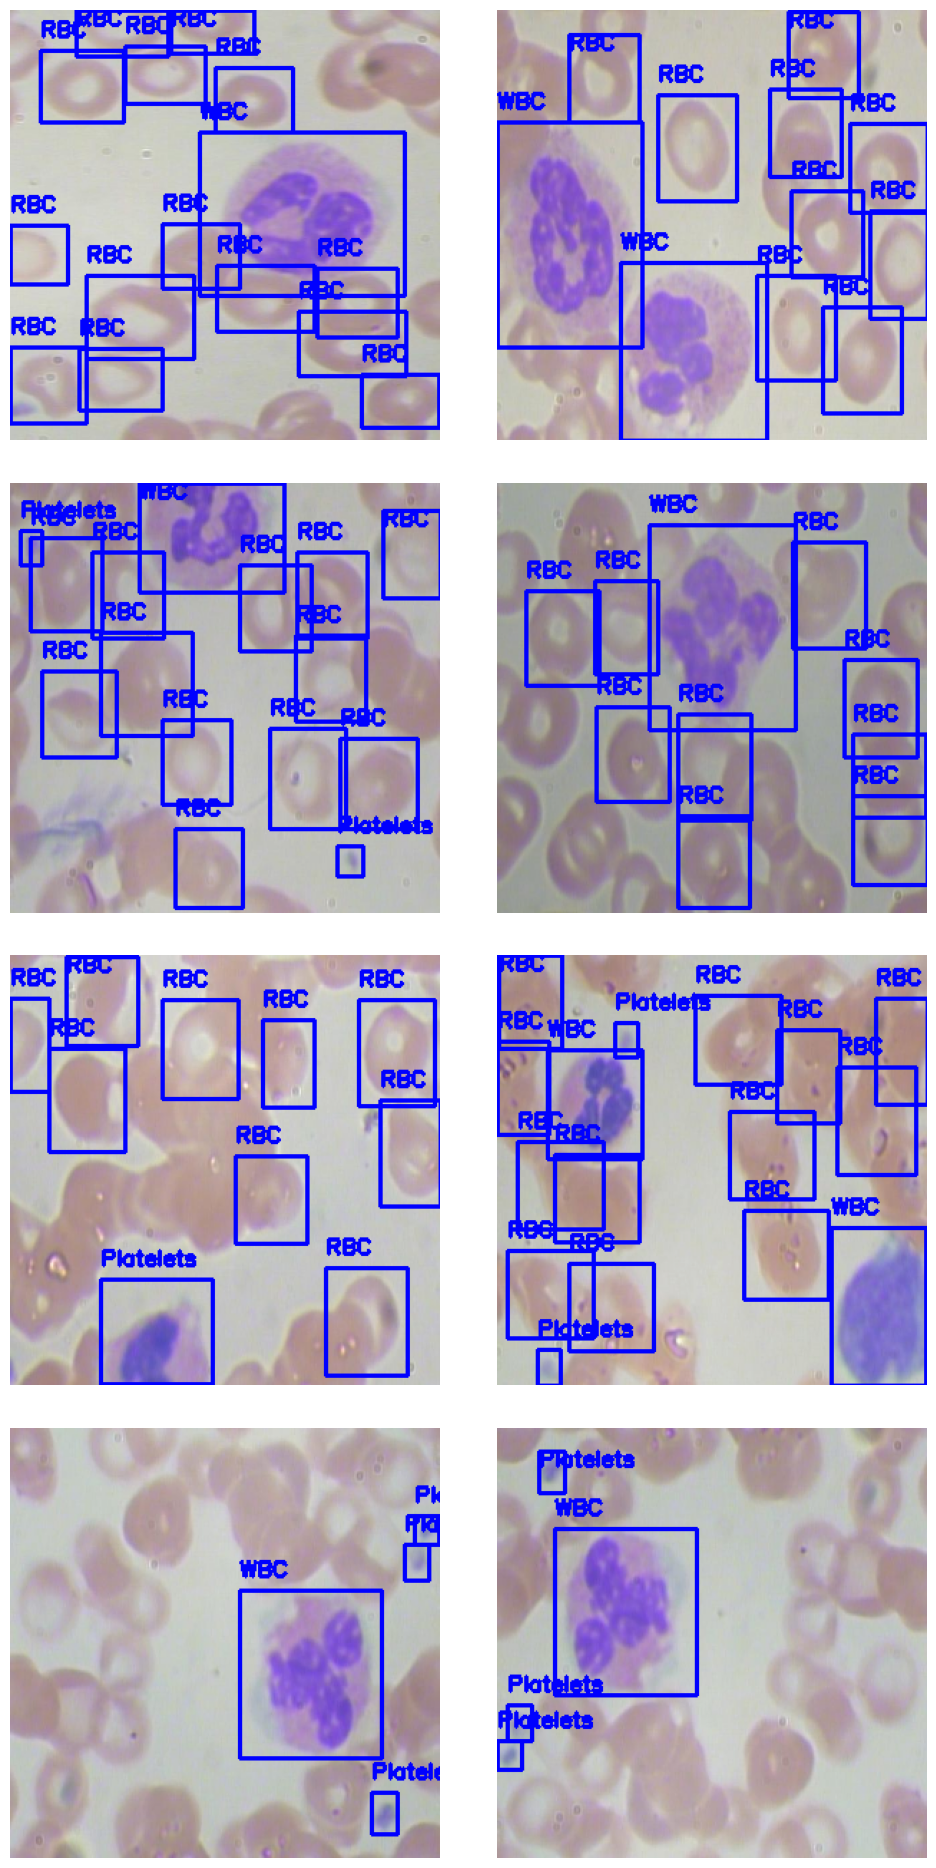

In [27]:
fig,axes=plt.subplots(4,2,figsize=(12,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()
idxs=np.random.choice(range(len(train_ds)),8)
for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    show_bbox(img,target,axis=ax[i])

In [33]:
train_dl=DataLoader(train_ds,batch_size=20,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=20,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

In [34]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
in_channels=det_utils.retrieve_out_channels(model.backbone,(300,300))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=3)

model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [35]:
for params in model.backbone.features.parameters():
    params.requires_grad=False

In [36]:
parameters=[params for params in model.parameters() if params.requires_grad]

optimizer=optim.Adam(parameters,lr=1e-4,weight_decay = 1e-4)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)

In [37]:
def get_lr(optimizer):
    """
    Get the learning rate from a PyTorch optimizer.
    Args:
        :param optimizer: The PyTorch optimizer.
    Returns:
        :return float: The learning rate of the optimizer's first parameter group.
    """
    for params in optimizer.param_groups:
        return params["lr"]

In [38]:
def asMinutes(s):
    """
    Convert seconds to a string in the format 'm minutes s seconds'.
    Parameters:
        :param s: Time in seconds.
    Returns:
        :return str: Formatted time string.
    """
    m = math.floor(s / 60)
    s -= m * 60
    return '%2dm %2ds' % (m, s)


def timeSince(since, percent):
    """
    Estimate the remaining time given the starting time and completion percentage.

    Parameters:
        :param since: The starting time (e.g., time.time() at the beginning of a process).
        :param percent: Completion percentage (0.0 to 1.0).

    Returns:
        :return str: Estimated remaining time string in the format 'm minutes s seconds (- remaining time)'.
    """
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [39]:
def save_model(model,optimizer,path='../models/'):
    """
    Save a PyTorch model and its optimizer's state to a file with a timestamped filename.

    Parameters:
    :param model: The PyTorch model to be saved.
    :param optimizer: The optimizer used for training the model.
    :param path: The directory path where the model checkpoint will be saved.
            Defaults to '../models/'.
            
    Example:
        save_model(neural_net, optimizer, path='../models/')
    """
    timestamp = datetime.now().strftime("%d-%m-%Y_%H:%M:%S")
    file_name = f'SSD300-model_{timestamp}.pth'
    file_path = os.path.join(path, file_name)
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'model_architecture': model,
    }
    
    torch.save(checkpoint,file_path)    

In [40]:
def load_model(path,optimizer = None):
    """
    Load a PyTorch model and, optionally, its optimizer from a saved checkpoint file.

    Parameters:
    :param path: The file path to the saved model checkpoint.
    :param optimizer: The optimizer to use for the loaded model.
            If provided, the optimizer's state is loaded from the checkpoint.
            Defaults to None.

    Returns:
        :return tuple or torch.nn.Module: A tuple containing the loaded PyTorch model and optimizer if available.
        If the optimizer is not provided, it returns only the loaded model.

    Example:
        loaded_model = load_model('path/to/model_checkpoint.pth')
        
        optimizer = torch.optim.SGD  # Replace with your actual optimizer
        loaded_model, loaded_optimizer = load_model('path/to/model_checkpoint.pth', optimizer=optimizer)
    """
    checkpoint = torch.load(path)
    model = checkpoint['model_architecture']
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None:
        optimizer = optimizer(model.parameters())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return model.to(device), optimizer
    
    return model.to(device)

In [41]:
def train_with_time_tracking(model, optimizer, train_dl, val_dl, epochs, lr_scheduler):
    """
    Train a PyTorch model and monitor training progress with time tracking.

    Parameters:
        :param model: The PyTorch model to train.
        :param optimizer: The optimizer used for training.
        :param train_dl: DataLoader for the training dataset.
        :param val_dl: DataLoader for the validation dataset.
        :param epochs: The number of training epochs.
        :param lr_scheduler: Learning rate scheduler for dynamic learning rates.
    Example:
        train_with_time_tracking(my_model, my_optimizer, train_loader, val_loader, epochs=10)
    """
    loss_history={"training_loss":[],
                  "validation_loss":[]}
    
    train_len=len(train_dl.dataset)
    val_len=len(val_dl.dataset)
    
    best_validation_loss=np.inf
    best_weights=copy.deepcopy(model.state_dict())
    
    start_time = time.time()
    
    for epoch in range(epochs):
        start_epoch = time.time()
        
        training_loss=0.0
        validation_loss=0.0
        
        current_lr=get_lr(optimizer)
        
        model.train()
        for imgs,targets in train_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
            
            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            training_loss+=losses.item()
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
        with torch.no_grad():
            for imgs,targets in val_dl:
                imgs=[img.to(device) for img in imgs]
                targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
                
                loss_dict=model(imgs,targets)
                losses=sum(loss for loss in loss_dict.values())
                validation_loss+=losses.item()
            
                
        lr_scheduler.step(validation_loss)
        if current_lr!=get_lr(optimizer):
            print("Loading best Model weights")
            model.load_state_dict(best_weights)
        
        if validation_loss<best_validation_loss:
            best_validation_loss=validation_loss
            best_weights=copy.deepcopy(model.state_dict())
            print("Updating Best Model weights")
            
        
        loss_history["training_loss"].append(training_loss/train_len)
        loss_history["validation_loss"].append(validation_loss/val_len)
                
        end_time = time.time()
        elapsed_time = end_time - start_epoch
    
        completion_percentage = (epoch + 1) / epochs
    
        print(f"\n{epoch+1}/{epochs}")
        print(f"Training Loss: {training_loss/train_len}")
        print(f"Validation Loss: {validation_loss/val_len}")
        print(f"Elapsed Time: {asMinutes(elapsed_time)}")
        print(f"Time Remaining: {timeSince(start_time, completion_percentage)}")
        print("\n" + "*" * 50)
        
    save_model(model=model,optimizer=optimizer)
    
    sns.lineplot(x=range(epochs),y=loss_history["training_loss"],label="Train Losses");
    sns.lineplot(x=range(epochs),y=loss_history["validation_loss"],label="Validation Losses");
    plt.title("Training Validation Datasets Losses Plot");
    plt.legend();

Updating Best Model weights

1/50
Training Loss: 0.38773621349799925
Validation Loss: 0.3376877609340624
Elapsed Time:  0m 11s
Time Remaining:  0m 11s (-  9m  3s)

**************************************************
Updating Best Model weights

2/50
Training Loss: 0.304029085577988
Validation Loss: 0.30400068458469437
Elapsed Time:  0m 10s
Time Remaining:  0m 21s (-  8m 39s)

**************************************************
Updating Best Model weights

3/50
Training Loss: 0.27446776366815334
Validation Loss: 0.2673314357626027
Elapsed Time:  0m 10s
Time Remaining:  0m 31s (-  8m 18s)

**************************************************
Updating Best Model weights

4/50
Training Loss: 0.24132913496436142
Validation Loss: 0.23562516289195795
Elapsed Time:  0m 10s
Time Remaining:  0m 42s (-  8m  4s)

**************************************************
Updating Best Model weights

5/50
Training Loss: 0.21565581531059452
Validation Loss: 0.21467150764903803
Elapsed Time:  0m 10s
Time Remaini

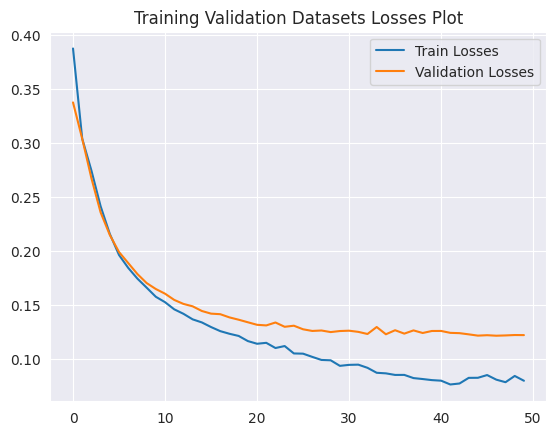

In [42]:
train_with_time_tracking(model=model,optimizer=optimizer,train_dl=train_dl,val_dl=val_dl,epochs=epochs,lr_scheduler=lr_scheduler)

In [43]:
def preprocess_bbox(prediction, threshold=0.5, iou_threshold=0.5):
    """
    Preprocess a set of bounding box predictions by filtering and applying non-maximum suppression.
    Parameters:
        :param prediction: A dictionary containing predicted bounding boxes, scores, and labels.
            It typically has the following keys: 'boxes', 'scores', 'labels'.
        :param threshold: Confidence threshold to filter bounding boxes. Default is 0.5.
        :param iou_threshold: Intersection over Union (IoU) threshold for non-maximum suppression. Default is 0.5.

    Returns:
        :return dict: A dictionary containing processed bounding boxes, scores, and labels after thresholding and NMS.
            It has the following keys: 'boxes', 'scores', 'labels'.
    Example:

        processed_prediction = preprocess_bbox(my_prediction)
    """
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

In [44]:
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

model.eval()
with torch.no_grad():
    for imgs,targets in val_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        predictions=model(imgs)
        
        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))
        
        metric.update(results,targets)
        
results=metric.compute()

In [45]:
mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.4039
Mean Average Precision @ 0.5          : 0.5746
Mean Average Precision @ 0.75         : 0.5062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

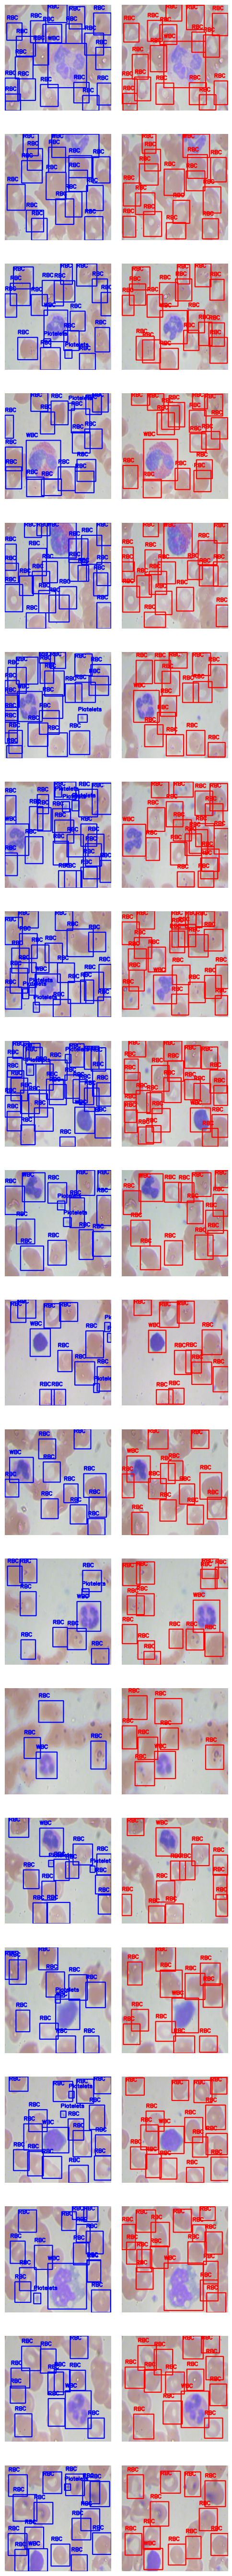

In [52]:
fig,axes=plt.subplots(20,2,figsize=(6,70))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(val_dl))
model.eval()
with torch.no_grad():
    output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    prediction=output[idx]
    
    #real bounding boxes
    show_bbox(img,targets[idx],axes[i,0],color=(0, 0, 139))
    
    #predicted bounding box
    predict=preprocess_bbox(prediction,threshold=threshold,iou_threshold=iou_threshold)
    
    show_bbox(img,predict,axes[i,1],color=(255,0,0));